# Load Library

In [1]:
import pandas as pd
import numpy as np
import pydicom 
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.chdir (r'C:\Users\solunkedi\OneDrive - VMware, Inc\Dinesh Solunke\Greate Learning Project\Capstone Project')
datapath = (r'C:\Users\solunkedi\OneDrive - VMware, Inc\Dinesh Solunke\Greate Learning Project\Capstone Project')
%matplotlib inline


# The Real Problem

# Problem Statement

# Load data

In [2]:
train_labels = pd.read_csv("stage_2_train_labels.csv")
train_info =  pd.read_csv("stage_2_detailed_class_info.csv")


In [3]:
print('Number of rows in main train dataset:', train_labels.shape[0])
print('Number of unique patient IDs:', train_labels['patientId'].nunique())

Number of rows in main train dataset: 30227
Number of unique patient IDs: 26684


# EDA

## Null Values

In [51]:
print(train_labels.info())
print('-----------------------------------------------------------')
print(train_labels.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None
-----------------------------------------------------------
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0

## Check Target 

0    20672
1     9555
Name: Target, dtype: int64
------------------------------------------------


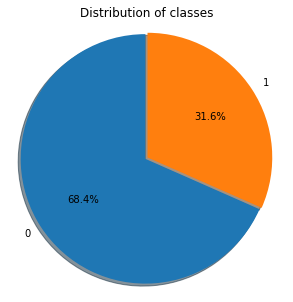

In [4]:
print(train_labels['Target'].value_counts())
print("------------------------------------------------")
counts=train_labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(counts.values, explode=explode, labels=counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Distribution of classes')
plt.show()

## Distribution of class

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64
------------------------------------------------


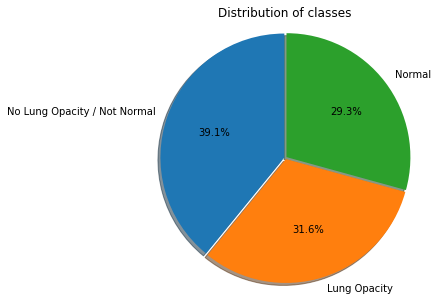

In [5]:
print(train_info['class'].value_counts())
print("------------------------------------------------")
counts=train_info['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(counts.values, explode=explode, labels=counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Distribution of classes')
plt.show()

## Check duplicate patient ID samples

In [6]:
similar_PI = train_labels[train_labels.duplicated(['patientId'])]
print(similar_PI.shape)
print(similar_PI.head())

(3543, 6)
                               patientId      x      y  width  height  Target
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
15  00aecb01-a116-45a2-956c-08d2fa55433f  547.0  299.0  119.0   165.0       1
17  00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  511.0  206.0   284.0       1
20  00f08de1-517e-4652-a04f-d1dc9ee48593  571.0  275.0  230.0   476.0       1


In [7]:
train_labels[train_labels.patientId=='00c0b293-48e7-4e16-ac76-9269ba535a62']

patientId      x      y  width  height  Target
16  00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  544.0  168.0   244.0       1
17  00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  511.0  206.0   284.0       1

## Bounding box

In [9]:
def has_sickness(patientId, train_labels):
    first = train_labels[train_labels.patientId == patientId].iloc[0]
    has_bounding_box = not np.isnan(first.x)
    return has_bounding_box

number_of_areas = {pId: (train_labels.patientId == pId).sum() if has_sickness(pId, train_labels) else 0 
                   for pId in train_labels.patientId.unique()}

In [10]:
values = np.fromiter(number_of_areas.values(), int)
print("Number of unique patients:", len(number_of_areas.keys()))
print("Max number of regions:", values.max())
print("Min number of regions:", values.min())
total_patients = len(number_of_areas.keys())
for i in range(values.max()):
    num_patients = (values == i).sum()
    print(f"Number of patients with {i} number of areas: {num_patients:5.0f} ({num_patients/total_patients*100:2.0f}%)")

Number of unique patients: 26684
Max number of regions: 4
Min number of regions: 0
Number of patients with 0 number of areas: 20672 (77%)
Number of patients with 1 number of areas:  2614 (10%)
Number of patients with 2 number of areas:  3266 (12%)
Number of patients with 3 number of areas:   119 ( 0%)


## Merge info and data

In [12]:
train = pd.concat([train_labels, train_info['class']], axis = 1)
train.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

## Getting the center position of each bounding box

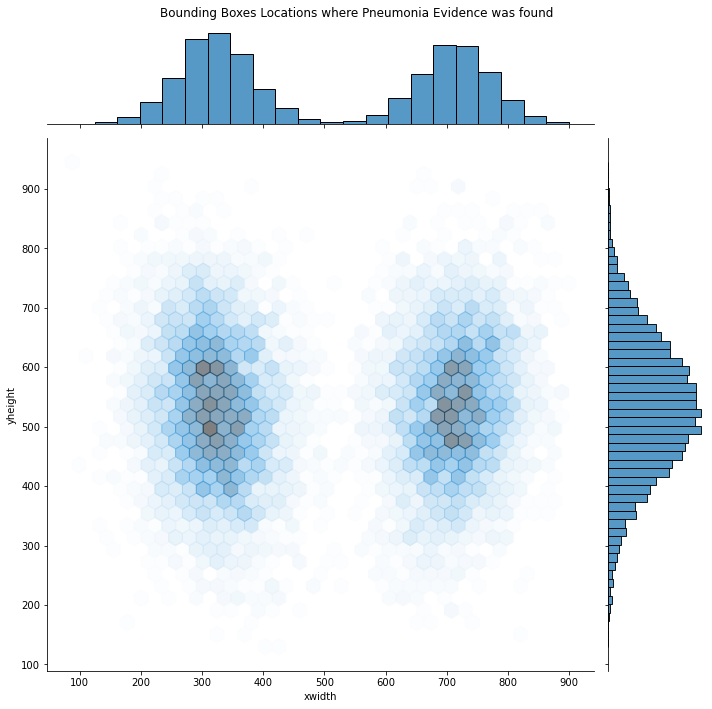

In [52]:
bounding_boxes = train[train['Target'] == 1]
bounding_boxes['xwidth'] = bounding_boxes['x'] + bounding_boxes['width'] / 2
bounding_boxes['yheight'] = bounding_boxes['y'] + bounding_boxes['height'] / 2

g = sns.jointplot(x = bounding_boxes['xwidth'], y = bounding_boxes['yheight'], data = bounding_boxes, 
                  kind = 'hex', alpha = 0.5, size = 10)
plt.suptitle('Bounding Boxes Locations where Pneumonia Evidence was found')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

## Distribution of ViewPosition

### Over all

In [54]:
import plotly.express as px
labels = ['AP', 'PA']
fig1 = px.pie(labels,values=train['ViewPosition'].value_counts(),names=labels,title='Distribution of ViewPosition,Overall')
fig1.show()

### Evidence of pneumonia

In [56]:
labels = ['AP', 'PA']
fig1 = px.pie(labels,values=train.loc[train['Target'] == 1, 'ViewPosition']
     .value_counts(),names=labels,title='Distribution of ViewPosition with eveidence of pneumonia')
fig1.show()

## Creating bins to categorise the age feature into 4 groups:

In [103]:
train['agebins'] = pd.cut(age['PatientAge'], bins = 4, precision = 0, labels = ['<=25', '<=50', '<=75', '<=100'])

age = pd.DataFrame((pd.concat([train['agebins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train.loc[train['Target'] == 1, 'agebins'].value_counts().sort_index()
                   .rename('Counts of Age Bins, Target=1')], axis = 1)))


age['Perc of Infected'] = round((age['Counts of Age Bins, Target=1']/age['Counts of Age Bins, Overall'])*100,2)

display(age)

Counts of Age Bins, Overall  Counts of Age Bins, Target=1  \
<=25                          3253                          1228   
<=50                         10480                          3485   
<=75                         14306                          4155   
<=100                         2183                           687   

       Perc of Infected  
<=25              37.75  
<=50              33.25  
<=75              29.04  
<=100             31.47

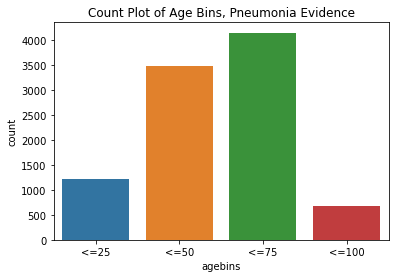

In [106]:
g = sns.countplot(x = train.loc[train['Target'] == 1, 'agebins']).set_title('Count Plot of Age Bins, Pneumonia Evidence')

##  Creating distribution of age with pneumonia evidence, by gender and count plot of gender

% Gender, Overall  % Gender, Target=1
F               0.43                0.42
M               0.57                0.58

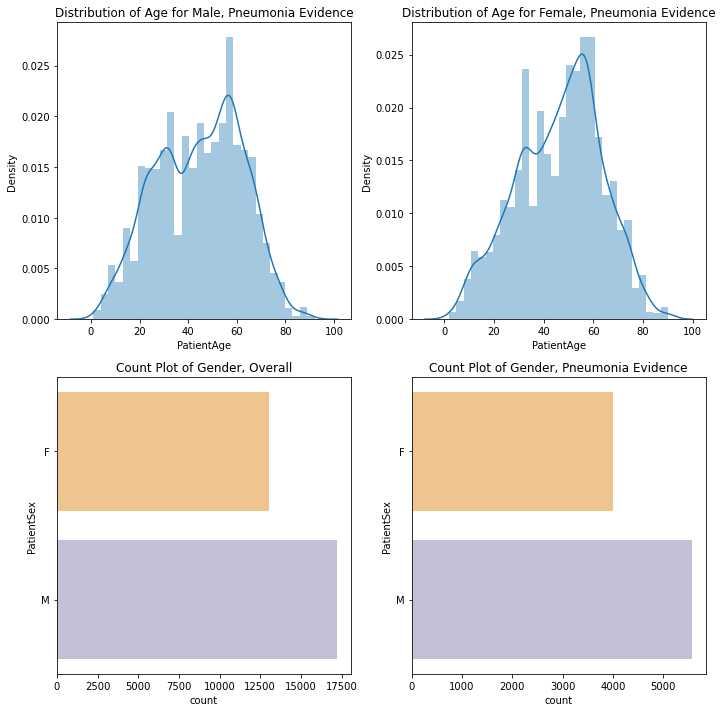

In [108]:
display(pd.concat([train['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train.loc[(train['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train.loc[(train['Target'] == 1) & (train['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train.loc[(train['Target'] == 1) & (train['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train.loc[(train['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

In [111]:
train.drop(['sex', 'age', 'agebins'], inplace = True, axis = 1)

## Correlation 

<AxesSubplot:>

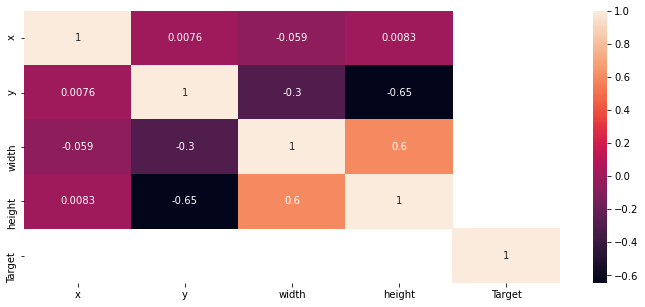

In [16]:
corr = train.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)


In [17]:
# have a look at the header meta-data of an image 
pId = train['patientId'].sample(1).values[0]    
dcmdata = pydicom.read_file(datapath+'/stage_2_train_images/'+pId+'.dcm')
print(dcmdata)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3957.1517874305.148659
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3957.1517874305.148659
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

## Analysing the dicom images

In [18]:
import matplotlib.patches as patches
import pydicom as dcm
import math

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = datapath+'/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

### With Sikness

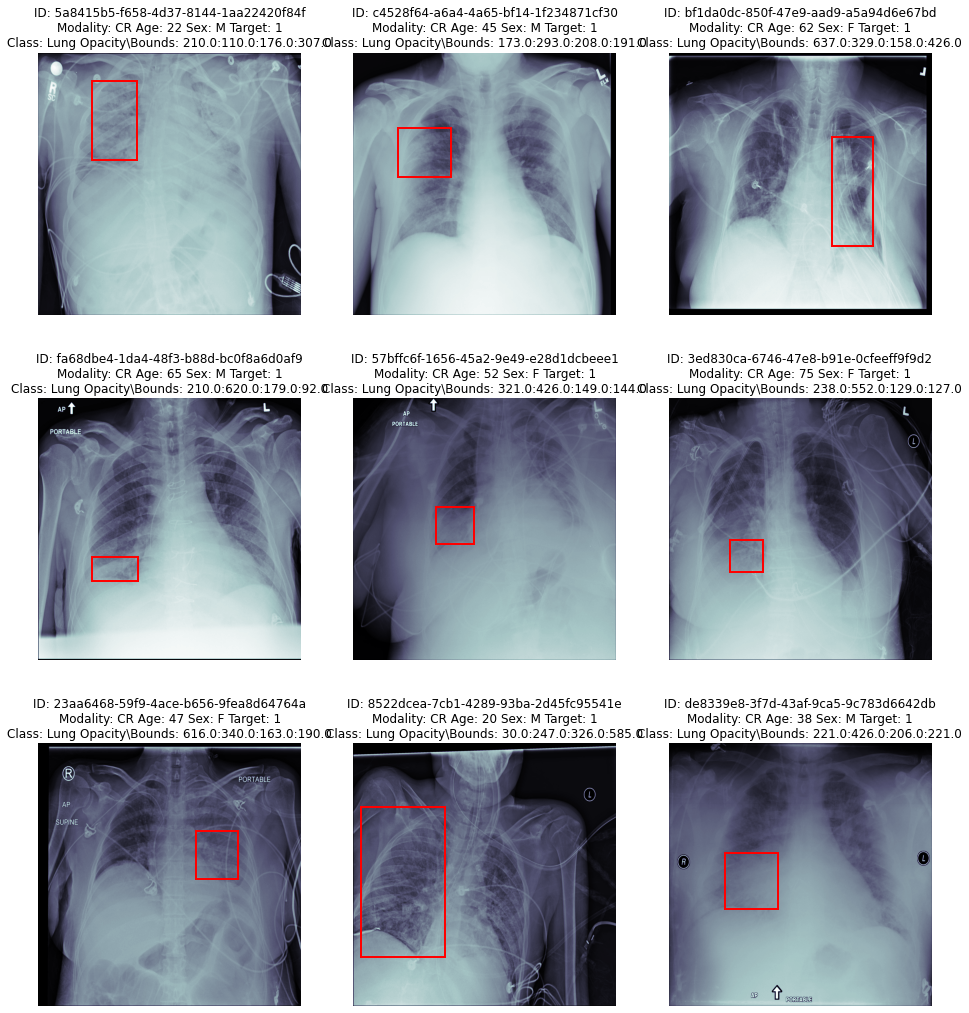

In [19]:
inspectImages(train[train['Target']==1].sample(9))

### Without Sickness

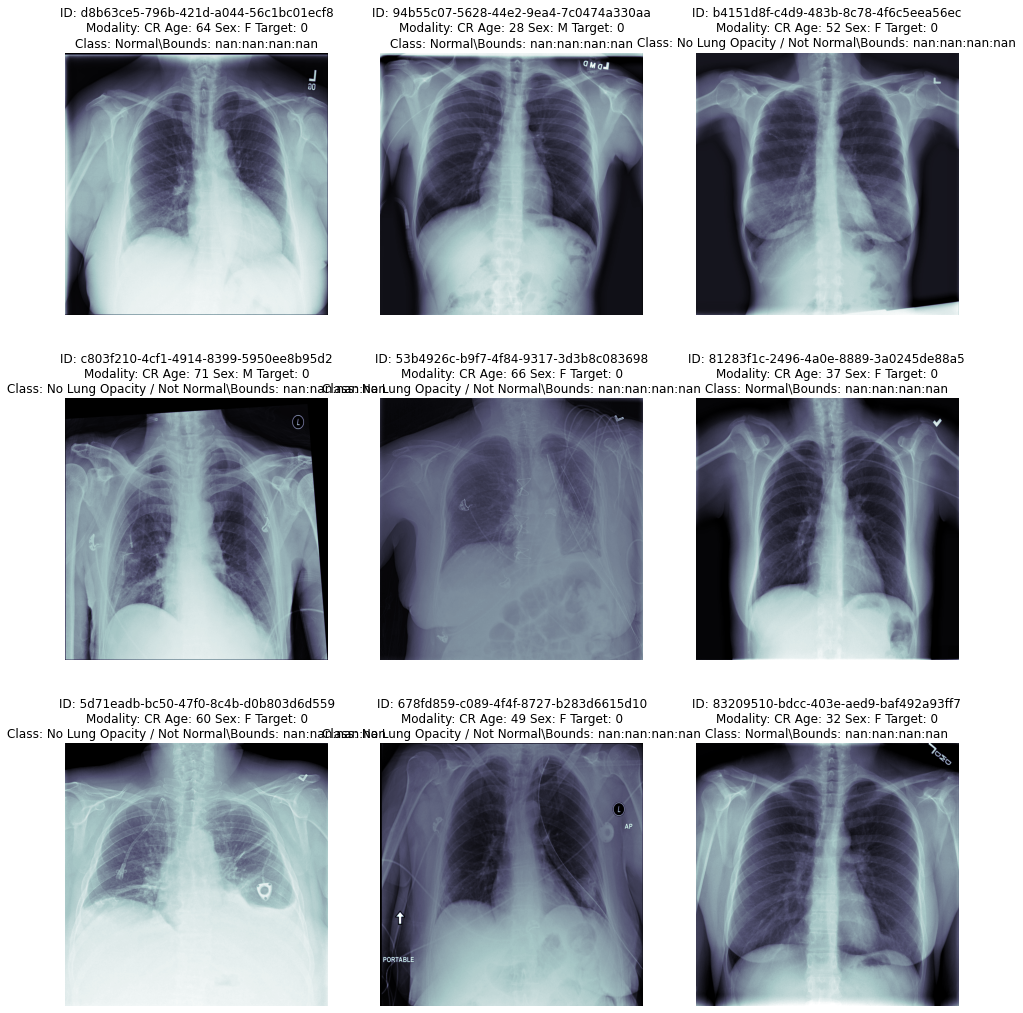

In [20]:
inspectImages(train[train['Target']==0].sample(9))

## Get Meta data of each patient

In [21]:
def get_dcm_data_per_patient(pId, sample='train'):
    '''
    Given one patient ID and the sample name (train/test), 
    return the corresponding dicom data.
    '''
    return pydicom.read_file(datapath+'/stage_2_'+sample+'_images/'+pId+'.dcm')

def get_metadata_per_patient(pId, attribute, sample='train'):
    '''
    Given a patient ID, return useful meta-data from the corresponding dicom image header.
    Return: 
    attribute value
    '''
    # get dicom image
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    # extract attribute values
    attribute_value = getattr(dcmdata, attribute)
    return attribute_value

In [22]:
# create list of attributes that we want to extract (manually edited after checking which attributes contained valuable information)
attributes = ['PatientSex', 'PatientAge', 'ViewPosition']
for a in attributes:
    train[a] = train['patientId'].apply(lambda x: get_metadata_per_patient(x, a, sample='train'))
# convert patient age from string to numeric
train['PatientAge'] = train['PatientAge'].apply(pd.to_numeric, errors='coerce')
# remove a few outliers
train['PatientAge'] = train['PatientAge'].apply(lambda x: x if x<120 else np.nan)
train.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class PatientSex  PatientAge ViewPosition  
0  No Lung Opacity / Not Normal          F        51.0           PA  
1  No Lung Opacity / Not Normal          F        48.0           PA  
2  No Lung Opacity / Not Normal          M        19.0           AP  
3                        Normal          M        28.0           PA  
4                  Lung Opacity          F        32.0           AP

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PatientAge', ylabel='Density'>

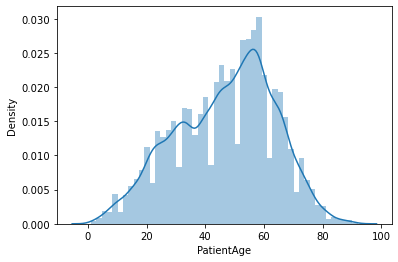

In [23]:
sns.distplot(train.PatientAge)

Text(0.5, 1.0, 'Sex and class for Chest Exams')

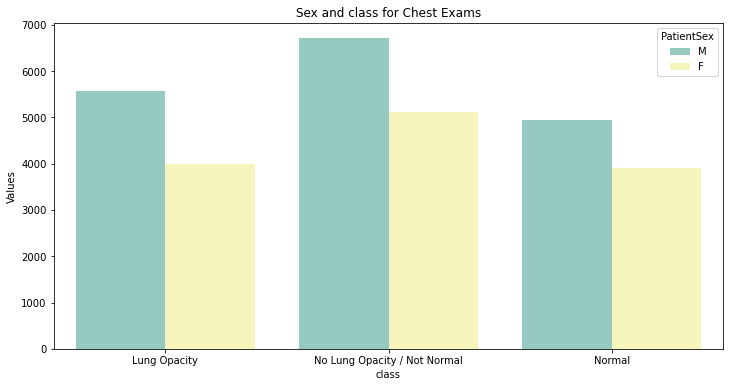

In [24]:
## Distbution of Sex Among the classes

fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = train.groupby('class')['PatientSex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'PatientSex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

# Model Building

## Reading the image data and append it to the training_data dataset

In [25]:
def readDCIMData(rowData):
    dcm_file = datapath+'/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [26]:
train['sex'], train['age'] = zip(*train.apply(readDCIMData, axis=1))

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patientId     30227 non-null  object 
 1   x             9555 non-null   float64
 2   y             9555 non-null   float64
 3   width         9555 non-null   float64
 4   height        9555 non-null   float64
 5   Target        30227 non-null  int64  
 6   class         30227 non-null  object 
 7   PatientSex    30227 non-null  object 
 8   PatientAge    30222 non-null  float64
 9   ViewPosition  30227 non-null  object 
 10  sex           30227 non-null  object 
 11  age           30227 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 2.8+ MB


## Take sample dataset

In [28]:
sample_trainigdata = train.groupby('class', group_keys=False).apply(lambda x: x.sample(3000))

## Checking the training data set with class distbution 
sample_trainigdata["class"].value_counts()

No Lung Opacity / Not Normal    3000
Normal                          3000
Lung Opacity                    3000
Name: class, dtype: int64

## Pre Processing the image

In [29]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [30]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = datapath+'/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [31]:
images,labels = populateImage(sample_trainigdata)

(9000, 128, 128, 3) (9000,)


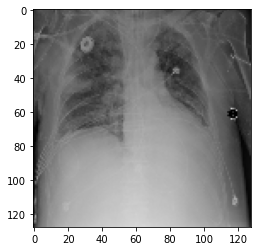

In [32]:
print(images.shape , labels.shape)
## The image is of 128*128 with 3 channels

## Checking one of the converted image 
plt.imshow(images[99])

In [33]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)